## ■ 네이버 영화 리뷰 감성 분류하기

In [ ]:
!pip install konlpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import urllib.request

from konlpy.tag import Okt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import time
import datetime


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


### 1) 데이터 가져오기  

In [ ]:
# 링크로부터 훈련 데이터에 해당하는 ratings_train.txt와 테스트 데이터에 해당하는 ratings_test.txt를 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")



('ratings_test.txt', <http.client.HTTPMessage at 0x7f027b1a7e10>)

In [ ]:
# Pandas를 이용하여 훈련 데이터는 train_data에 테스트 데이터는 test_data에 저장

train_data = pd.read_table('ratings_train.txt')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
test_data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/웹과텍스트마이닝기말프로젝트/영화리뷰.csv',encoding='cp949')

In [ ]:
test_data

,id,document,label
0,1,"1, 2편보다 스케일이 커진 것만 좋았다",1
1,2,사람이 해골로 변 할때 제작진이 제정신이 아닙니다 보지 마세요,0
2,3,보다가 화가 난 영화는 이게 처음임...,0
3,4,"처음 봤을땐 억지 사골 속편이라 생각했건만.. 4, 5편 뇌절 후 다시 보니 선녀",1
4,5,엄청난 액션이 겁나 많아서 좋음,1
...,...,...,...
156,157,오씨엔 스릴즈에서 해주는데 다크페이트보다 훨 재밌고 제거장면 연출은 저의 심장을 두...,1
157,158,흐미 이 영화가 7점대야? 폭망한 영화였는데. 1.2화를 봤으면 이 영화 던져버림....,0
158,159,3편도 나쁘지 않다.,1
159,160,내용을 떠나서 3편의 아놀드는 그나마 젊은편?이라 봐줄만함. 이후 시리즈는 안나오는...,1


In [ ]:

print('◎ 훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력


◎ 훈련용 리뷰 개수 : 150000


In [ ]:
# 해당 데이터는 id, document, label 총 3개의 열로 구성
#  id는 감성 분류에서 배제 

# label : 긍정 평가는 1 , 부정 평가는 0 으로 구분 

train_data[:5]



,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:

print('◎ 테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력


◎ 테스트용 리뷰 개수 : 160


In [ ]:

test_data[:5]


,id,document,label
0,1,편보다 스케일이 커진 것만 좋았다,1
1,2,사람이 해골로 변 할때 제작진이 제정신이 아닙니다 보지 마세요,0
2,3,보다가 화가 난 영화는 이게 처음임,0
3,4,처음 봤을땐 억지 사골 속편이라 생각했건만 편 뇌절 후 다시 보니 선녀,1
4,5,엄청난 액션이 겁나 많아서 좋음,1


### 2) 데이터 정제하기

In [ ]:

train_data['document'].nunique(), train_data['label'].nunique()



(146182, 2)

In [ ]:
# document 열에서 중복인 내용이 있다면 중복 제거 

train_data.drop_duplicates(subset=['document'], inplace=True) 



In [ ]:
print('◎ 총 샘플의 수 :',len(train_data))



◎ 총 샘플의 수 : 146183


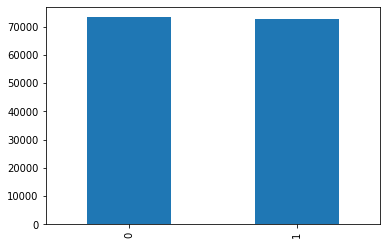

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')


In [ ]:
# Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 확인 

train_data.loc[train_data.document.isnull()]



,id,document,label
25857,2172111,NaN,1


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 1개만 있어도 drop (default 값) 

print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인


False


In [ ]:
print(len(train_data))



146182


In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거

train_data[:5]


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', "")  # white space 데이터를 empty value로 변경

train_data['document'].replace('', np.nan, inplace=True)

print(train_data.isnull().sum())



id            0
document    789
label         0
dtype: int64


In [ ]:

train_data.loc[train_data.document.isnull()][:5]


,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [ ]:
# NUll 샘플을 다시 제거 

train_data = train_data.dropna(how = 'any')

print(len(train_data))



145393


In [ ]:
# test 데이터에 지금까지 진행했던 전처리 과정들을 동일하게 진행

test_data.drop_duplicates(subset = ['document'], inplace=True) 
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "")

test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

print('◎ 전처리 후 테스트용 샘플의 개수 :',len(test_data))


◎ 전처리 후 테스트용 샘플의 개수 : 160


### 3) 토큰화

In [ ]:
# 불용어 정의 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


okt = Okt()

okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)   # 사용 예  


['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [ ]:
# train_data에 형태소 분석기를 사용하여 토큰화 & 불용어를 제거하여 X_train에 저장

X_train = []

start = time.time()    # 시작 시간 기록 ==============================


for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)
    

processing_time = time.time() - start    # 경과 시간 계산  ==============================
times = str(datetime.timedelta(seconds = processing_time))  
print()   
print('▶ 수행 시간 = ', times)



▶ 수행 시간 =  0:08:49.462980


In [ ]:
# 상위 3개의 샘플만 출력하여 결과를 확인

print(X_train[:3])



[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [ ]:
# test 데이터에 대해서도 동일하게 토큰화를 진행

X_test = []

start = time.time()    # 시작 시간 기록 ==============================


for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
    
    
processing_time = time.time() - start    # 경과 시간 계산  ==============================
times = str(datetime.timedelta(seconds = processing_time))  
print()   
print('▶ 수행 시간 = ', times)



▶ 수행 시간 =  0:00:00.585211


### 4) 정수 인코딩

- 컴퓨터가  텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행

In [ ]:
# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

print('◎ 전체 단어 수 = ', len(tokenizer.word_index))


◎ 전체 단어 수 =  43752


In [ ]:

threshold = 3

total_words = len(tokenizer.word_index)      # 전체 단어의 수

rare_words = 0     # 등장 빈도수가 threshold보다 작은 단어의 개수

total_freq = 0        # 훈련 데이터의 전체 단어 빈도수 총 합

rare_freq = 0         # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합


for key, value in tokenizer.word_counts.items():   # 단어와 출현 빈도수의 쌍(pair)을 key와 value로 받음 
    total_freq = total_freq + value

    if(value < threshold):        # 단어의 등장 빈도수가 threshold보다 작은지 check 
        rare_words = rare_words + 1
        rare_freq = rare_freq + value


print('◎ 단어 집합(vocabulary)의 크기 :',total_words)
print('◎ 등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_words))
print('◎ 단어 집합에서 희귀 단어의 비율: ', round((rare_words / total_words)*100,3))
print('◎ 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: ', round((rare_freq / total_freq)*100,3))


◎ 단어 집합(vocabulary)의 크기 : 43752
◎ 등장 빈도가 2번 이하인 희귀 단어의 수: 24337
◎ 단어 집합에서 희귀 단어의 비율:  55.625
◎ 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:  1.872


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거 
# 0번 패딩 토큰을 고려하여 + 1

vocab_size = total_words - rare_words + 1

print('◎ 단어 집합의 크기 :',vocab_size)


◎ 단어 집합의 크기 : 19416


In [ ]:
# 단어 집합을 Keras Tokenizer의 인자로 넘겨주면, Keras Tokenizer는 텍스트 시퀀스를 숫자 시퀀스로 변환

tokenizer = Tokenizer(vocab_size) 

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

X_test = tokenizer.texts_to_sequences(X_test)


In [ ]:
# train_data & test_data 에는 현재 전처리가 완료된 원본 데이터가 저장되어 있음 
#
# train_data & test_data에서 y_train과 y_test를 별도로 저장

y_train = np.array(train_data['label'])

y_test = np.array(test_data['label'])


### 5) 빈 샘플(empty samples) 제거

- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미

In [ ]:

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]


In [ ]:
# 빈 샘플들을 제거하고 확인 

X_train = np.delete(X_train, drop_train, axis=0)

y_train = np.delete(y_train, drop_train, axis=0)

print('◎ 빈 샘플 제거후 X_train 크기 = ', len(X_train))

print('◎ 빈 샘플 제거후 y_train 크기 = ', len(y_train)) 



◎ 빈 샘플 제거후 X_train 크기 =  145162
◎ 빈 샘플 제거후 y_train 크기 =  145162


### 6) 패딩

- 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞추어 주어야 함 

◎ 리뷰의 최대 길이 : 69
◎ 리뷰의 평균 길이 : 10.812485361182679


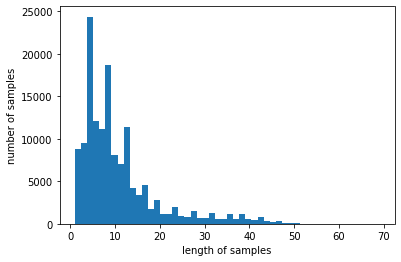

In [ ]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행
#
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 확인 

print('◎ 리뷰의 최대 길이 :',max(len(l) for l in X_train))

print('◎ 리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(s) for s in X_train], bins=50)

plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [ ]:
# 최적의 리뷰 길이를 찾기 위해 함수를 정의 


def below_threshold_len(max_len, nested_list):
  count = 0
  for row in nested_list:
    if(len(row) <= max_len):
        count = count + 1
  print('◎ 전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [ ]:
# 위 그래프를 참조하여 일단 리뷰 길이를 30으로 하여 확인 해봄 

max_len = 30

below_threshold_len(max_len, X_train)


◎ 전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [ ]:
# 모든 샘플의 길이를 30으로 맞추어 줌 

X_train = pad_sequences(X_train, maxlen = max_len)

X_test = pad_sequences(X_test, maxlen = max_len)


### 7) LSTM으로 네이버 영화 리뷰 감성 분류하기

In [ ]:

from tensorflow.keras.layers import Embedding, Dense, LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# 리뷰 분류를 위해서 LSTM을 사용

model = Sequential()

model.add(Embedding(vocab_size, 100))    # 단어 임베딩 벡터의 차원 : 100

model.add(LSTM(128))                     # hidden state capacity : 128

model.add(Dense(1, activation='sigmoid'))    # 긍정 & 부정 이진분류 

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1941600   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,058,977
Trainable params: 2,058,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후이므로 검증 데이터 손실이 4회 이내 개선되지 않으면 학습을 조기 종료(Early Stopping)
# 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [ ]:
# epoch는 총 15번을 수행
# 또한 훈련 데이터 중 20%를 검증 데이터로 사용하면서 정확도를 확인
# epoch 당 약 15~16초 정도 소요 
# epoch 8~9 정도에서 조기 종료 (약 2분~3분 정도 소요)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

start = time.time()    # 시작 시간 기록 ==============================

history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

processing_time = time.time() - start    # 경과 시간 계산  ==============================
times = str(datetime.timedelta(seconds = processing_time))  
print()   
print('▶ 수행 시간 = ', times)


Epoch 1/15
1929/1936 [============================>.] - ETA: 0s - loss: 0.3898 - acc: 0.8230
Epoch 1: val_acc improved from -inf to 0.84421, saving model to best_model.h5
1936/1936 [==============================] - 19s 8ms/step - loss: 0.3898 - acc: 0.8230 - val_loss: 0.3524 - val_acc: 0.8442
Epoch 2/15
1936/1936 [==============================] - ETA: 0s - loss: 0.3282 - acc: 0.8579
Epoch 2: val_acc improved from 0.84421 to 0.85485, saving model to best_model.h5
1936/1936 [==============================] - 15s 8ms/step - loss: 0.3282 - acc: 0.8579 - val_loss: 0.3347 - val_acc: 0.8549
Epoch 3/15
1932/1936 [============================>.] - ETA: 0s - loss: 0.3020 - acc: 0.8718
Epoch 3: val_acc improved from 0.85485 to 0.85665, saving model to best_model.h5
1936/1936 [==============================] - 14s 7ms/step - loss: 0.3020 - acc: 0.8718 - val_loss: 0.3280 - val_acc: 0.8566
Epoch 4/15
1932/1936 [============================>.] - ETA: 0s - loss: 0.2836 - acc: 0.8810
Epoch 4: val_acc

In [ ]:
# 훈련이 다 되었다면 이제 테스트 데이터에 대해서 정확도를 측정
# 훈련 과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 'best_model.h5'를 로드

loaded_model = load_model('best_model.h5')

print("\n ◎ 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


5/5 [==============================] - 0s 4ms/step - loss: 0.3823 - acc: 0.8313

 ◎ 테스트 정확도: 0.8313


### 8) 리뷰 예측해보기

In [ ]:
# 직접 작성한 리뷰에 대해서 예측하는 함수


def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    
    score = float(loaded_model.predict(pad_new)) # 예측
    
    if(score > 0.5):
        print("◎ {:.2f}% 확률로 긍정 😃 리뷰입니다.\n".format(score * 100)) 
    else :
        print("◎ {:.2f}% 확률로 부정 😰 리뷰입니다.\n".format((1 - score) * 100))
    
    

In [ ]:
# 키워드에 대해 리뷰 테스트

sentiment_predict('미래')



◎ 84.19% 확률로 긍정 😃 리뷰입니다.



In [ ]:

sentiment_predict('우주')



◎ 53.04% 확률로 부정 😰 리뷰입니다.



In [ ]:


sentiment_predict('로봇')



◎ 76.23% 확률로 부정 😰 리뷰입니다.



## 수고하셨습니다. 😀